## Manipulating Molecules
- Create Fragments

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage, IPythonConsole

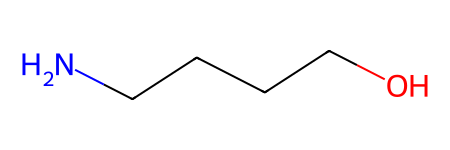

In [3]:
mol = Chem.MolFromSmiles("O-C-C-C-C-N")
mol

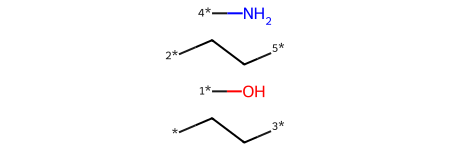

In [8]:
# Chem.FragmentOnBonds() will fragment all specified bond indices at once, and return a single molecule
# with all specified cuts applied. By default, addDummies=True, so empty valences are filled with dummy atoms:
mol_fragment = Chem.FragmentOnBonds(mol, (0,2,4))
mol_fragment


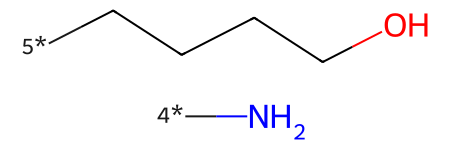

In [13]:
mol_fragment = Chem.FragmentOnSomeBonds(mol,(0,2,4))
mol_fragment[2]


- Largest Fragment

In [17]:
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem.MolStandardize import rdMolStandardize

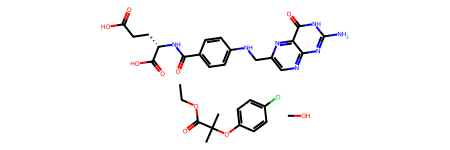

In [18]:
mol = Chem.MolFromSmiles('CCOC(=O)C(C)(C)OC1=CC=C(C=C1)Cl.CO.C1=CC(=CC=C1C(=O)N[C@@H](CCC(=O)O)C(=O)O)NCC2=CN=C3C(=N2)C(=O)NC(=N3)N')
mol

In [19]:
mol_frags = rdmolops.GetMolFrags(mol, asMols = True)
largest_mol = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
print(Chem.MolToSmiles(largest_mol))

Nc1nc2ncc(CNc3ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc3)nc2c(=O)[nH]1


In [21]:
# setup standardization module
largest_Fragment = rdMolStandardize.LargestFragmentChooser()
largest_mol = largest_Fragment.choose(mol)
print(Chem.MolToSmiles(largest_mol))

Nc1nc2ncc(CNc3ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc3)nc2c(=O)[nH]1


[10:59:09] Running LargestFragmentChooser
[10:59:09] Fragment: CCOC(=O)C(C)(C)Oc1ccc(Cl)cc1
[10:59:09] New largest fragment: CCOC(=O)C(C)(C)Oc1ccc(Cl)cc1 (31)
[10:59:09] Fragment: CO
[10:59:09] Fragment: Nc1nc2ncc(CNc3ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc3)nc2c(=O)[nH]1
[10:59:09] New largest fragment: Nc1nc2ncc(CNc3ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc3)nc2c(=O)[nH]1 (51)


- Sidechain-Core Enumeration

In [22]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

In [25]:
# core is '*c1c(C)cccc1(O)'
# chain is 'CN*'

rxn = AllChem.ReactionFromSmarts('[c:1][#0].[#0][*:2]>>[c:1]-[*:2]')
reacts = (Chem.MolFromSmiles('*c1c(C)cccc1(O)'),Chem.MolFromSmiles('CN*'))
products = rxn.RunReactants(reacts) # tuple
print(len(products))
# [0][0] to index out the rdchem mol object
print(Chem.MolToSmiles(products[0][0])) 

1
CNc1c(C)cccc1O


In [26]:
# The above reaction-based approach is flexible, 
# however if you can generate your
# sidechains in such a way that the atom you want to attach to the core
# is the first one (atom zero), there's a somewhat easier way to do this
# simple replacement:
core = Chem.MolFromSmiles('*c1c(C)cccc1(O)')
chain = Chem.MolFromSmiles('NC')
products = Chem.ReplaceSubstructs(core,Chem.MolFromSmarts('[#0]'),chain) 
# tuple
print(Chem.MolToSmiles(products[0]))

CNc1c(C)cccc1O


['C[n+]1cc[nH]c1', 'CC[n+]1cc[nH]c1', 'CCC[n+]1cc[nH]c1', 'CCCC[n+]1cc[nH]c1', 'CCCCC[n+]1cc[nH]c1', 'CCCCCC[n+]1cc[nH]c1']


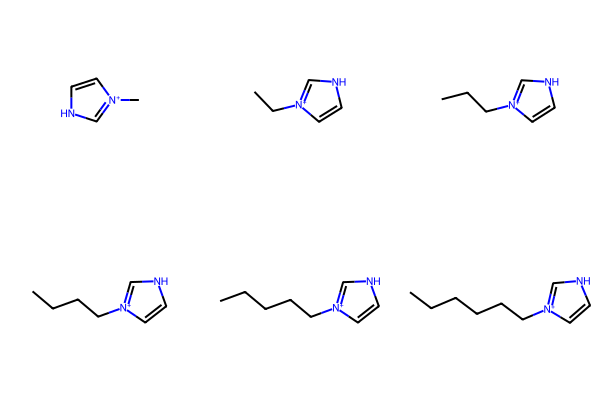

In [28]:
# Here is an example in a loop for an imidazolium core with alkyl chains

core = Chem.MolFromSmiles('*[n+]1cc[nH]c1')
chains = ['C','CC','CCC','CCCC','CCCCC','CCCCCC']
chainMols = [Chem.MolFromSmiles(chain) for chain in chains]

product_smi = []
for chainMol in chainMols:
    product_mol = Chem.ReplaceSubstructs(core,Chem.MolFromSmarts('[#0]'),chainMol)
    product_smi.append(Chem.MolToSmiles(product_mol[0]))
print(product_smi)
# View the enumerated molecules:
Draw.MolsToGridImage([Chem.MolFromSmiles(smi) for smi in product_smi])

- Neutralizing Molecules:
This neutralize_atoms() algorithm is adapted from Noel O’Boyle’s nocharge code. It is a neutralization by atom approach and neutralizes atoms with a +1 or -1 charge by removing or adding hydrogen where possible. The SMARTS pattern checks for a hydrogen in +1 charged atoms and checks for no neighbors with a negative charge (for +1 atoms) and no neighbors with a positive charge (for -1 atoms), this is to avoid altering molecules with charge separation (e.g., nitro groups).

In [29]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

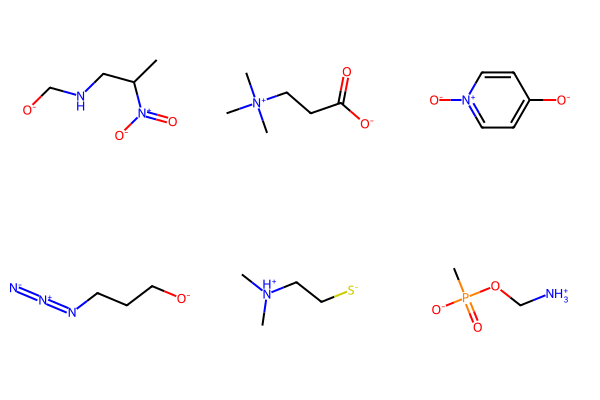

In [30]:
# list of SMILES
smiList = ['CC(CNC[O-])[N+]([O-])=O',
       'C[N+](C)(C)CCC([O-])=O',
       '[O-]C1=CC=[N+]([O-])C=C1',
       '[O-]CCCN=[N+]=[N-]',
       'C[NH+](C)CC[S-]',
       'CP([O-])(=O)OC[NH3+]']

# Create RDKit molecular objects
mols = [Chem.MolFromSmiles(m) for m in smiList]

# display
Draw.MolsToGridImage(mols,molsPerRow=3,subImgSize=(200,200))

CC(CNCO)[N+](=O)[O-]
C[N+](C)(C)CCC(=O)O
[O-][n+]1ccc(O)cc1
[N-]=[N+]=NCCCO
CN(C)CCS
CP(=O)(O)OCN


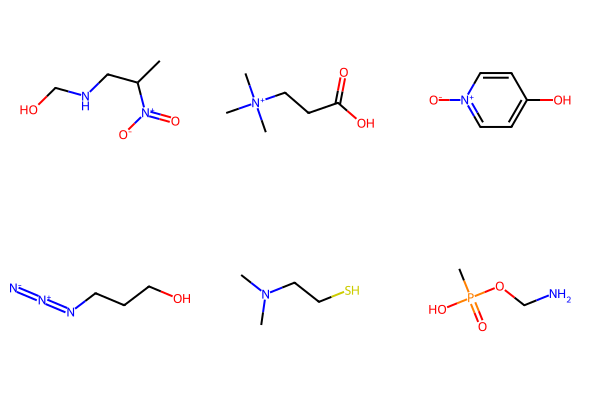

In [32]:
def neutralize_atoms(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return mol

# Neutralize molecules by atom
for mol in mols:
    neutralize_atoms(mol)
    print(Chem.MolToSmiles(mol))
Draw.MolsToGridImage(mols,molsPerRow=3, subImgSize=(200,200))